In [1]:
%load_ext lab_black

import warnings

warnings.filterwarnings("ignore")

# Chapter 1: Basics and Linear Models

## Exercise on linear regression

In [2]:
# Via scikit-learn
import pandas as pd
from plotnine.data import diamonds
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse

y = diamonds["price"]
cat_vars = ["color", "cut", "clarity"]
lvl = [diamonds[x].cat.categories.to_list() for x in cat_vars]

model = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("linear", "passthrough", ["carat"]),
            ("dummies", OneHotEncoder(categories=lvl, drop="first"), cat_vars),
        ],
        verbose_feature_names_out=False,
    ),
    LinearRegression(),
)
model.fit(diamonds, y)

print(f"RMSE: {mse(y, model.predict(diamonds), squared=False):.3f}")
print(f"R-squared: {model.score(diamonds, y):.2%}")
print("Intercept", model[-1].intercept_)

results = pd.DataFrame(
    model[-1].coef_, columns=["Estimates"], index=model[:-1].get_feature_names_out()
)
results

RMSE: 1156.648
R-squared: 91.59%
Intercept -7362.802156301801


,Estimates
carat,8886.128883
color_E,-211.682481
color_F,-303.310033
color_G,-506.199536
color_H,-978.697665
color_I,-1440.301902
color_J,-2325.222360
cut_Good,655.767448
cut_Very Good,848.716878
cut_Premium,869.395903


In [3]:
# Via statsmodels
from plotnine.data import diamonds
from statsmodels.formula.api import ols

model2 = ols("price ~ carat + color + cut + clarity", data=diamonds).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 3.264e+04
Date:                Wed, 27 Apr 2022   Prob (F-statistic):               0.00
Time:                        20:59:00   Log-Likelihood:            -4.5699e+05
No. Observations:               53940   AIC:                         9.140e+05
Df Residuals:                   53921   BIC:                         9.142e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -7362.8022     51.684   -142.458      0.000   -7464.103   -7261.501
color[T.E]        -211.6825     18.316    -11.557      0.000    -247.582    -175.783
color[T.F]        -303.3100     18.509    -16.387      0.000    -339.589    -267.031
color[T.G]        -506.1995     18.122    -27.933      0.000    -541.719    -470.680
color[T.H]        -978.6977     19.272    -50.784      0.000   -1016.471    -940.925
color[T.I]       -1440.3019     21.646    -66.538      0.000   -1482.729   -1397.875
color[T.J]       -2325.2224     26.723    -87.013      0.000   -2377.599   -2272.846
cut[T.Good]        655.7674     33.634     19.497      0.000     589.844     721.690
cut[T.Very Good]   848.7169     31.277     27.135      0.000     787.414     910.020
cut[T.Premium]     869.3959     30.931     28.108      0.000     808.771     930.021
cut[T.Ideal]       998.2544     30.656     32.563      0.000     938.168    1058.341
clarity[T.SI2]    2625.9500     44.788     58.630      0.000    2538.164    2713.736
clarity[T.SI1]    3573.6880     44.598     80.132      0.000    3486.276    3661.100
clarity[T.VS2]    4217.8291     44.841     94.061      0.000    4129.940    4305.719
clarity[T.VS1]    4534.8790     45.535     99.591      0.000    4445.630    4624.128
clarity[T.VVS2]   4967.1994     46.891    105.932      0.000    4875.293    5059.105
clarity[T.VVS1]   5072.0276     48.211    105.205      0.000    4977.534    5166.521
clarity[T.IF]     5419.6468     52.136    103.952      0.000    5317.460    5521.834
carat             8886.1289     12.034    738.437      0.000    8862.543    8909.715
==============================================================================
Omnibus:                    15285.474   Durbin-Watson:                   0.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183262.957
Skew:                           1.022   Prob(JB):                         0.00
Kurtosis:                      11.796   Cond. No.                         37.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
from sklearn.metrics import mean_squared_error as mse

print(f"RMSE: {mse(y, model2.predict(diamonds), squared=False):.3f}")

RMSE: 1156.648


**Comments**

- **Model quality:** About 92% of price variations are explained by covariates. Typical prediction error is 1157 USD.
- **Effects:** All effects point into the intuitively right direction (larger stones are more expensive, worse color are less expensive etc.)
- **Practical perspective:** Additivity in color, cut and clarity are not making sense. Their effects should get larger with larger diamond size. This can be solved by adding interaction terms with carat or, much easier, to switch to a logarithmic response.

## Exercise on GLMs

In [5]:
# Via statsmodels
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine.data import diamonds

model = smf.glm(
    "price ~ np.log(carat) + color + cut + clarity",
    data=diamonds,
    family=sm.families.Gamma(sm.families.links.log()),
).fit()
print(model.summary())

bias = diamonds["price"].mean() / model.predict(diamonds).mean() - 1
print(f"Relative bias on USD scale: {bias:.3%}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                53940
Model:                            GLM   Df Residuals:                    53921
Model Family:                   Gamma   Df Model:                           18
Link Function:                    log   Scale:                        0.019471
Method:                          IRLS   Log-Likelihood:            -3.8857e+05
Date:                Wed, 27 Apr 2022   Deviance:                       978.68
Time:                        20:59:01   Pearson chi2:                 1.05e+03
No. Iterations:                    12   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.8933      0.006  

In [6]:
# Via scikit-learn
import numpy as np
import pandas as pd
from plotnine.data import diamonds
from sklearn.linear_model import GammaRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

cat_vars = ["color", "cut", "clarity"]
lvl = [diamonds[x].cat.categories.to_list() for x in cat_vars]

y = diamonds["price"]

# Define log_carat outside pipeline as it is tricky to track feature names
diamonds["log_carat"] = np.log(diamonds["carat"])

# Define and fit model pipeline. Note: GammaRegressor directly uses log-link
model2 = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("linear", "passthrough", ["log_carat"]),
            ("dummies", OneHotEncoder(categories=lvl, drop="first"), cat_vars),
        ],
        verbose_feature_names_out=False,
    ),
    GammaRegressor(alpha=0, max_iter=10_000, tol=1e-6),
)
model2.fit(diamonds, y)

# Performance
d2 = model2.score(diamonds, y)
print(f"Percent deviance explained: {d2:.2%}")

# Relative bias
bias2 = y.mean() / model2.predict(diamonds).mean() - 1
print(f"Relative bias on USD scale: {bias2:.3%}")

# Fitted coefficients
print("Intercept", model2[-1].intercept_)
results = pd.DataFrame(
    model2[-1].coef_, columns=["Estimates"], index=model2[:-1].get_feature_names_out()
)
results

Percent deviance explained: 98.15%
Relative bias on USD scale: 0.336%
Intercept 7.893246729902202


,Estimates
log_carat,1.881551
color_E,-0.056288
color_F,-0.096361
color_G,-0.163522
color_H,-0.253494
color_I,-0.374268
color_J,-0.511086
cut_Good,0.071694
cut_Very Good,0.108288
cut_Premium,0.132444


**Comment:** The coefficients are very similar to the linear regression with log(price) as response. This makes sense as we interpret the coefficients in the same way! The bias is only 0.3%, i.e., much smaller than the 3% of the OLS with log(price) as response. Still, because the log is not the natural link of the Gamma regression, the bias is not exactly 0.

# Chapter 2: Model Selection and Validation

## Exercise 1

In [7]:
import numpy as np
from plotnine.data import diamonds
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    FunctionTransformer,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)

ord_vars = ["color", "cut", "clarity"]
lvl = [diamonds[x].cat.categories.to_list() for x in ord_vars]

# THIS IS THE DECIDING LINE
dia = diamonds.drop_duplicates(["price", "carat"] + ord_vars)

# Split data into train and test
df_train, df_test, y_train, y_test = train_test_split(
    dia, dia["price"], test_size=0.1, random_state=49
)

# Define CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=4432)

# Cross-validation performance of linear regression
linear_regression = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("log", FunctionTransformer(np.log), ["carat"]),
            ("dummies", OneHotEncoder(categories=lvl, drop="first"), ord_vars),
        ]
    ),
    LinearRegression(),
)
results_linear = -cross_val_score(
    linear_regression,
    X=df_train,
    y=y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv,
)
print(f"Linear regression CV RMSE: {results_linear.mean():.3f}")

# Cross-validation performance of k-nearest-neighbour for k = 1-20
knn_encoder = ColumnTransformer(
    transformers=[
        ("linear", "passthrough", ["carat"]),
        ("ordered", OrdinalEncoder(categories=lvl), ord_vars),
    ],
)
knn_regression = Pipeline(
    steps=[
        ("encoder", knn_encoder),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=5)),
    ]
)
search = GridSearchCV(
    knn_regression,
    param_grid={"knn__n_neighbors": range(1, 21)},
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=4302),
)
# Note: the best model is being refitted on full training data
search.fit(X=df_train, y=y_train)
print(f"Best k of k-NN: {search.best_params_}")
print(f"Its CV-RMSE: {-search.best_score_:.3f}")
print("Best model seems 6-NN!")

Linear regression CV RMSE: 1945.513
Best k of k-NN: {'knn__n_neighbors': 6}
Its CV-RMSE: 718.314
Best model seems 6-NN!


In [8]:
# The overall best model is 6-nearest-neighbour
final_rmse = mse(y_test, search.predict(df_test), squared=False)
print(f"Test RMSE of final model: {final_rmse:.3f}")

Test RMSE of final model: 664.725


**Comments:** The test performance of the best model (6-NN) seems clearly worse than the one without deduplication (~660 USD RMSE vs ~580). Overall, this is probably the more realistic performance than the one obtained from the original data set. Still, as certain rows could be identical by chance, our deduplication approach might be slightly too conservative. The true performance will probably be somewhere between the two approaches.

## Exercise 2

In [9]:
import numpy as np
import pandas as pd
from plotnine.data import diamonds
from sklearn.linear_model import GammaRegressor
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# Split data into train and test
df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.1, random_state=49
)

# Define parametrized end-to-end preprocessor with GLM on top of it
cat_vars = ["color", "cut", "clarity"]
lvl = [diamonds[x].cat.categories.to_list() for x in cat_vars]

prep_carat = Pipeline(
    steps=[("log", FunctionTransformer(np.log)), ("poly", PolynomialFeatures(degree=1))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("carat", prep_carat, ["carat"]),
        ("dummies", OneHotEncoder(categories=lvl, drop="first"), cat_vars),
    ]
)

gamma_regression = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("glm", GammaRegressor(alpha=0, max_iter=10_000, tol=1e-6)),
    ]
)

In [10]:
# Grid search for best polynomial degree (takes 1.5 minutes)
param_grid = {"preprocessor__carat__poly__degree": range(1, 11)}

search = GridSearchCV(
    gamma_regression,
    param_grid=param_grid,
    scoring="neg_mean_gamma_deviance",
    cv=KFold(n_splits=5, shuffle=True, random_state=4302),
)
search.fit(X=df_train, y=y_train)

# Organize results
results = pd.DataFrame(
    -search.cv_results_["mean_test_score"],
    index=param_grid["preprocessor__carat__poly__degree"],
    columns=["mean_gamma_deviance"],
)
results

,mean_gamma_deviance
1,0.018230
2,0.018056
3,0.016280
4,0.016277
5,0.016224
6,0.016079
7,0.015997
8,0.015960
9,0.015994
10,0.016165


In [11]:
# The model was automatically refitted on the train data with optimal degree:
print(f"Mean deviance on the test data: {-search.score(df_test, y_test):.3f}")

Mean deviance on the test data: 0.015


**Comments:** The optimal degree seems to be 8 with a CV deviance of 0.016. The test performance is not too different. Caution: Instead of using such high degree polynomial, it is almost always better to use regression splines.

## Exercise 3 (optional)

Solution not shown here.

# Chapter 3: Trees

## Exercises on Random Forests

### Exercise 1

In [12]:
import numpy as np
from plotnine.data import diamonds
from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Stratified train/test split
binner = KBinsDiscretizer(n_bins=10, encode="ordinal")
y_binned = binner.fit_transform(diamonds[["price"]])

df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=341, stratify=y_binned
)

# Pipeline with model
ord_features = ["cut", "color", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_features]

model = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("ordinal", OrdinalEncoder(categories=ord_levels), ord_features),
            ("numeric", FunctionTransformer(np.log), ["carat"]),
        ]
    ),
    RandomForestRegressor(
        n_estimators=500,
        max_features="sqrt",
        min_samples_leaf=5,
        oob_score=True,
        random_state=17,
        n_jobs=4,
    ),
)
model.fit(df_train, y_train)

# OOB performance
print(f"OOB R-squared: {model[-1].oob_score_:.2%}")

OOB R-squared: 98.07%


In [13]:
# Test performance
rmse_test = mean_squared_error(y_test, model.predict(df_test), squared=False)
print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test R-squared: {model.score(df_test, y_test):.2%}")

Test RMSE: 554.874
Test R-squared: 98.05%


**Comment:** The results are essentially identical because log is a monotonic trafo. Differences might come from implementation tricks.

### Exercise 2

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

car = pd.read_csv("car.csv")  # see readme how to get the data

# Train/test split (stratified split is simple for discrete responses)
df_train, df_test, y_train, y_test = train_test_split(
    car, car["clm"], test_size=0.2, random_state=5684, stratify=car["clm"]
)

# Model pipeline. For simplicity, we treat 'veh_body' as ordinal
num_vars = ["veh_value", "veh_age", "agecat"]
ord_vars = ["gender", "area", "veh_body"]
ord_levels = [sorted(car[v].unique()) for v in ord_vars]

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(categories=ord_levels), ord_vars),
        ("numeric", "passthrough", num_vars),
    ]
)

rf = RandomForestClassifier(
    n_estimators=500,
    max_features="sqrt",
    min_samples_leaf=5,
    criterion="entropy",
    max_depth=8,
    n_jobs=4,  # or set n_jobs in GridSearchCV
)

model = Pipeline(steps=[("preprocessor", preprocessor), ("rf", rf)])

In [15]:
# Grid search for 'max_depth' with CV and five (stratified) folds
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(
    model, param_grid={"rf__max_depth": range(3, 8)}, scoring="neg_log_loss", cv=5
)
# Remember: the best model is refitted on training data
search.fit(X=df_train, y=y_train)
print(f"Best max_depth: {search.best_params_}")

Best max_depth: {'rf__max_depth': 5}


In [16]:
# Performance on test data
from sklearn.metrics import log_loss

y_pred = search.predict_proba(df_test)
test_loss = log_loss(y_test, search.predict_proba(df_test))
test_loss0 = log_loss(y_test, np.repeat(y_train.mean(), len(y_test)))
rel_imp = (test_loss0 - test_loss) / test_loss0

print(f"Average test log loss: {test_loss: .3f}")
print(f"Relative improvement in average log loss: {rel_imp: .3%}")

Average test log loss:  0.248
Relative improvement in average log loss:  0.240%


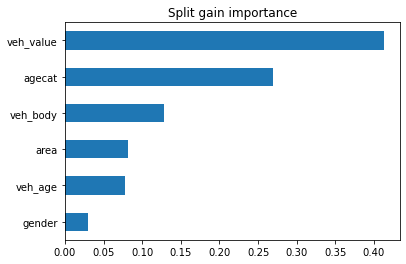

In [17]:
# Variable importance
# Replace later with: feature_names = search[:-1].get_feature_names_out()
feature_names = ord_vars + num_vars  # same(!!) order as in pipeline
imps = pd.Series(search.best_estimator_[-1].feature_importances_, index=feature_names)
_ = imps.sort_values().plot(kind="barh", title="Split gain importance")

In [18]:
# Partial dependence plots
# Note: As soon as sklearn.inspect.PartialDependenceDisplay
# allows for passing a character grid, it is an option as well.
import dalex as dx

# Define explainer
exp = dx.Explainer(
    search,
    data=df_train,
    predict_function=lambda m, X: m.predict_proba(X)[:, 1],
    verbose=False,
)

# Plots
num_eval_at = {
    "veh_value": np.linspace(0, 5, 41),
    "agecat": sorted(car["agecat"].unique()),
    "veh_age": sorted(car["veh_age"].unique()),
}
pdp_num = exp.model_profile(
    variable_splits=num_eval_at,
    label="Partial depencence for numeric variables",
    verbose=False,
)
pdp_num.plot(facet_scales="free")

pdp_cat = exp.model_profile(
    variable_type="categorical",
    variable_splits=dict(zip(ord_vars, ord_levels)),
    label="Partial depencence for categorical variables",
    verbose=False,
)
pdp_cat.plot(facet_scales="free")

**Comment:** Test performance with small tree depth seems to be best. When studying relative performance metrics like the relative deviance gain, we can see that performance of the model is very low. TPL claims seem to be mostly determined by bad luck, which makes sense.

## Exercises on Boosting

### Exercise 1

In [19]:
import json
from pathlib import Path
import pandas as pd
import xgboost as xgb
from plotnine.data import diamonds
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

# General settings
grid_file = Path("gridsearch") / "diamonds_xgb.txt"

# Train/test split
df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=341
)

# Preprocessing
ord_features = ["cut", "color", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_features]

encoder = make_column_transformer(
    (OrdinalEncoder(categories=ord_levels), ord_features), ("passthrough", ["carat"])
)

X_train = encoder.fit_transform(df_train)
X_test = encoder.transform(df_test)

# XGBoost data interface (feature_names are added for importance plot)
feature_names = ord_features + ["carat"]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

In [20]:
# Load grid
with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")

In [21]:
# Add constraints to best parameter combo
best = search_df.iloc[0]
best.params["monotone_constraints"] = "(0, 0, 0, 1)"

# Fit on best params
fit = xgb.train(params=best.params, dtrain=dtrain, num_boost_round=best.num_boost_round)

In [22]:
# Interpret model
import numpy as np
import dalex as dx

# Partial dependence plots on training data
def pred_fun(model, df):
    X = encoder.transform(df)
    dX = xgb.DMatrix(X, feature_names=feature_names)
    return model.predict(dX)


exp = dx.Explainer(fit, df_train, predict_function=pred_fun, verbose=False)

pdp_num = exp.model_profile(
    variable_splits={"carat": np.linspace(0, 3, 41)},
    label="Partial depencence for carat",
    verbose=False,
)
pdp_num.plot()

**Comment:** The argument is called "monotone_constraints". For each covariate, a value 0 means no constraint, a value -1 means a negative constraints, and a value 1 means positive constraint. Applying the constraint now leads to a monotonically increasing partial dependence plot. This is extremely useful in practice. Besides monotonic constraints, also interaction constraints are possible.

### Exercise 2

In [23]:
# We adapt the template from the lecture notes
import json
from pathlib import Path
import pandas as pd
import xgboost as xgb
from plotnine.data import diamonds
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

# Load data
car = pd.read_csv("car.csv")  # see readme how to get the data

# General settings
grid_file = Path("gridsearch") / "claims_xgb.txt"
objective = "binary:logistic"
metric = "logloss"

# Train/test split stratified on the response
df_train, df_test, y_train, y_test = train_test_split(
    car, car["clm"], test_size=0.2, random_state=341, stratify=car["clm"]
)

# Preprocessing
num_features = ["veh_value", "veh_age", "agecat"]
ord_features = ["gender", "area", "veh_body"]
ord_levels = [sorted(car[v].unique()) for v in ord_features]

encoder = make_column_transformer(
    (OrdinalEncoder(categories=ord_levels), ord_features), ("passthrough", num_features)
)

X_train = encoder.fit_transform(df_train)
X_test = encoder.transform(df_test)

# XGBoost data interface (feature_names are added for importance plot)
feature_names = ord_features + num_features  # same order as in encoder
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

In [24]:
# Step 1: Find learning rate with reasonable tree count
if True:
    params = {"learning_rate": 0.02, "objective": objective, "eval_metric": metric}

    # Cross-validation
    cvm = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=5000,
        nfold=5,
        stratified=True,
        early_stopping_rounds=20,
        callbacks=[xgb.callback.EvaluationMonitor(period=50)],
    )

    # A LR of 0.02 provides about 200 trees, which is convenient
    print("Best boosting round with default params:\n", cvm.tail(1))

[0]	train-logloss:0.67838	test-logloss:0.67838
[50]	train-logloss:0.33646	test-logloss:0.33716
[100]	train-logloss:0.26348	test-logloss:0.26579
[150]	train-logloss:0.24713	test-logloss:0.25146
[200]	train-logloss:0.24287	test-logloss:0.24916
[242]	train-logloss:0.24151	test-logloss:0.24904
Best boosting round with default params:
      train-logloss-mean  train-logloss-std  test-logloss-mean  \
223            0.242031           0.000396           0.249019   

     test-logloss-std  
223          0.000565  


In [25]:
# Step 2: Iterate randomized SearchCV for regularization parameters
if False:
    from tqdm import tqdm
    from sklearn.model_selection import ParameterSampler  # , ParameterGrid

    # Use ParameterGrid(...) if grid is small enough to check all combinations

    # Final grid search after some iterations
    grid = ParameterSampler(
        {
            "learning_rate": [0.02],
            "objective": [objective],
            "eval_metric": [metric],
            "max_depth": [3, 4, 5, 6],
            "min_child_weight": [0.1, 1],
            "colsample_bytree": [0.8, 1],
            "subsample": [0.8, 1],
            "reg_lambda": [0, 2.5, 5, 7.5],
            "reg_alpha": [0, 4],
            # "tree_method": ["hist"],   # when data is large
            "min_split_loss": [0, 0.0001],
        },
        n_iter=20,
    )

    # Iterate over grid and save relevant information on disk
    search = []
    for g in tqdm(grid):
        cvm = xgb.cv(
            params=g,
            dtrain=dtrain,
            num_boost_round=5000,
            nfold=5,
            stratified=True,
            early_stopping_rounds=20,
        )
        # Keep number of rounds, cv score, train score, and parameters
        search.append((len(cvm), *cvm.iloc[-1, [2, 0]], g))

        with open(grid_file, "w") as f:
            json.dump(search, f)

# Load grid and check (A) sort order and (B) if grid ranges were set reasonable
with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")

with pd.option_context("display.max_colwidth", None):
    display(search_df.head())

,num_boost_round,cv_score,train_score,params
3,307,0.248089,0.246847,"{'subsample': 0.8, 'reg_lambda': 7.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.02, 'eval_metric': 'logloss', 'colsample_bytree': 0.8}"
16,281,0.248094,0.246733,"{'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0.0001, 'min_child_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.02, 'eval_metric': 'logloss', 'colsample_bytree': 1}"
12,275,0.248096,0.246724,"{'subsample': 0.8, 'reg_lambda': 2.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0.0001, 'min_child_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.02, 'eval_metric': 'logloss', 'colsample_bytree': 1}"
7,293,0.248144,0.246953,"{'subsample': 1, 'reg_lambda': 7.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0, 'min_child_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.02, 'eval_metric': 'logloss', 'colsample_bytree': 0.8}"
0,275,0.248150,0.246779,"{'subsample': 1, 'reg_lambda': 2.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0.0001, 'min_child_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.02, 'eval_metric': 'logloss', 'colsample_bytree': 1}"


In [26]:
# Step 3: Fit on best params
best = search_df.iloc[0]

fit = xgb.train(params=best.params, dtrain=dtrain, num_boost_round=best.num_boost_round)

Average test log loss:  0.248
Relative improvement in average log loss:  0.434%


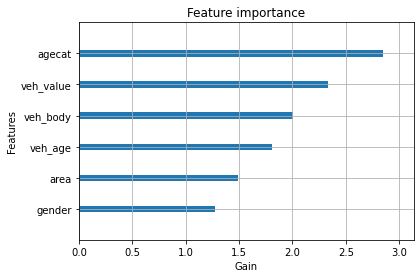

In [27]:
# Interpret model
import numpy as np
import dalex as dx
from sklearn.metrics import log_loss
from xgboost import plot_importance

# Variable importance regarding MSE improvement
plot_importance(fit, importance_type="gain", show_values=False, xlabel="Gain")

# Set up explainer object
def pred_fun(m, df):
    X = encoder.transform(df)
    dX = xgb.DMatrix(X, feature_names=feature_names)
    return m.predict(dX)


exp = dx.Explainer(fit, df_train, predict_function=pred_fun, verbose=False)

# Test performance
test_loss = log_loss(y_test, exp.predict(df_test))
test_loss0 = log_loss(y_test, np.repeat(y_train.mean(), len(y_test)))
rel_imp = (test_loss0 - test_loss) / test_loss0

print(f"Average test log loss: {test_loss: .3f}")
print(f"Relative improvement in average log loss: {rel_imp: .3%}")

In [28]:
# Partial dependence plots on training data
num_eval_at = {
    "veh_value": np.linspace(0, 5, 41),
    "agecat": sorted(car["agecat"].unique()),
    "veh_age": sorted(car["veh_age"].unique()),
}
pdp_num = exp.model_profile(
    variable_splits=num_eval_at,
    label="Partial depencence for numeric variables",
    verbose=False,
)
pdp_num.plot(facet_scales="free")

pdp_ord = exp.model_profile(
    variable_type="categorical",
    variable_splits=dict(zip(ord_features, ord_levels)),
    label="Partial depencence for ordinal variables",
    verbose=False,
)
pdp_ord.plot(facet_scales="free")

### Exercise 3 (Optional)

In [29]:
# We adapt the code from Exercise 2
import json
from pathlib import Path
import pandas as pd
import lightgbm as lgb
from plotnine.data import diamonds
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

# Load data
car = pd.read_csv("car.csv")  # see readme how to get the data

# General settings
grid_file = Path("gridsearch") / "claims_lgb.txt"
objective = "binary"
metric = "binary_logloss"

# Train/test split stratified on the response
df_train, df_test, y_train, y_test = train_test_split(
    car, car["clm"], test_size=0.2, random_state=341, stratify=car["clm"]
)

# Preprocessing
num_features = ["veh_value", "veh_age", "agecat"]
ord_features = ["gender", "area", "veh_body"]
ord_levels = [sorted(car[v].unique()) for v in ord_features]

encoder = make_column_transformer(
    (OrdinalEncoder(categories=ord_levels), ord_features), ("passthrough", num_features)
)

X_train = encoder.fit_transform(df_train)
X_test = encoder.transform(df_test)

# LGB data interface (feature_names are added for importance plot)
feature_names = ord_features + num_features  # same order as in encoder
dtrain = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
dtest = lgb.Dataset(X_test, label=y_test, feature_name=feature_names)

In [30]:
# Step 1: Find learning rate with reasonable tree count
if True:
    params = {
        "learning_rate": 0.005,
        "objective": objective,
        "metric": metric,
        "verbose": -1,
    }

    # Cross-validation
    cvm = lgb.cv(
        params=params,
        train_set=dtrain,
        num_boost_round=5000,
        nfold=5,
        stratified=True,
        eval_train_metric=True,
        callbacks=[lgb.log_evaluation(period=0), lgb.early_stopping(20, verbose=0)],
    )

In [31]:
# A LR of 0.005 provides about 200 trees, which is convenient
cvm = pd.DataFrame(cvm)
print("Best boosting round with default params:\n", len(cvm))
cvm.tail(1)

Best boosting round with default params:
 209


,train binary_logloss-mean,train binary_logloss-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
208,0.244967,0.000104,0.248199,0.000356


In [32]:
# Step 2: Iterate randomized SearchCV for regularization parameters
if False:
    from tqdm import tqdm
    from sklearn.model_selection import ParameterSampler  # , ParameterGrid

    # Use ParameterGrid(...) if grid is small enough to check all combinations

    # Final grid search after some iterations
    grid = ParameterSampler(
        {
            "learning_rate": [0.005],
            "objective": [objective],
            "metric": [metric],
            "num_leaves": [15, 31, 63],
            "min_data_in_leaf": [20],  # Fixed dataset parameter
            "min_sum_hessian_in_leaf": [0.001, 0.1],
            "colsample_bynode": [0.8, 1],
            "bagging_fraction": [0.8, 1],
            "lambda_l1": [0, 4],
            "lambda_l2": [0, 2.5, 5, 7.5],
            "verbose": [-1],
        },
        n_iter=20,
    )

    # Iterate over grid and save relevant information on disk
    search = []
    for g in tqdm(grid):
        cvm = lgb.cv(
            params=g,
            train_set=dtrain,
            num_boost_round=5000,
            nfold=5,
            stratified=True,
            eval_train_metric=True,
            callbacks=[lgb.log_evaluation(period=0), lgb.early_stopping(20, verbose=0)],
        )
        # Keep number of rounds, cv score, train score, and parameters
        cvm = pd.DataFrame(cvm)
        search.append((len(cvm), *cvm.iloc[-1, [2, 0]], g))

        with open(grid_file, "w") as f:
            json.dump(search, f)

# Load grid and check (A) sort order and (B) if grid ranges were set reasonable
with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")

In [33]:
with pd.option_context("display.max_colwidth", None):
    display(search_df.head())

,num_boost_round,cv_score,train_score,params
9,256,0.248139,0.246698,"{'verbose': -1, 'objective': 'binary', 'num_leaves': 15, 'min_sum_hessian_in_leaf': 0.1, 'min_data_in_leaf': 20, 'metric': 'binary_logloss', 'learning_rate': 0.005, 'lambda_l2': 7.5, 'lambda_l1': 0, 'colsample_bynode': 0.8, 'bagging_fraction': 0.8}"
11,218,0.248163,0.246542,"{'verbose': -1, 'objective': 'binary', 'num_leaves': 15, 'min_sum_hessian_in_leaf': 0.001, 'min_data_in_leaf': 20, 'metric': 'binary_logloss', 'learning_rate': 0.005, 'lambda_l2': 0, 'lambda_l1': 0, 'colsample_bynode': 1, 'bagging_fraction': 0.8}"
13,192,0.248170,0.245753,"{'verbose': -1, 'objective': 'binary', 'num_leaves': 31, 'min_sum_hessian_in_leaf': 0.001, 'min_data_in_leaf': 20, 'metric': 'binary_logloss', 'learning_rate': 0.005, 'lambda_l2': 2.5, 'lambda_l1': 0, 'colsample_bynode': 0.8, 'bagging_fraction': 1}"
19,192,0.248170,0.245753,"{'verbose': -1, 'objective': 'binary', 'num_leaves': 31, 'min_sum_hessian_in_leaf': 0.1, 'min_data_in_leaf': 20, 'metric': 'binary_logloss', 'learning_rate': 0.005, 'lambda_l2': 2.5, 'lambda_l1': 0, 'colsample_bynode': 0.8, 'bagging_fraction': 1}"
15,175,0.248181,0.245952,"{'verbose': -1, 'objective': 'binary', 'num_leaves': 31, 'min_sum_hessian_in_leaf': 0.001, 'min_data_in_leaf': 20, 'metric': 'binary_logloss', 'learning_rate': 0.005, 'lambda_l2': 2.5, 'lambda_l1': 0, 'colsample_bynode': 1, 'bagging_fraction': 0.8}"


In [34]:
# Step 3: Fit on best params
best = search_df.iloc[0]

fit = lgb.train(
    params=best.params, train_set=dtrain, num_boost_round=best.num_boost_round
)

Average test log loss:  0.248
Relative improvement in average log loss:  0.399%


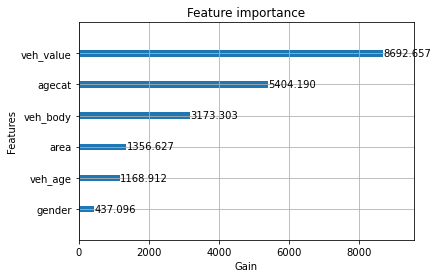

In [35]:
# Interpret model
import numpy as np
import dalex as dx
from sklearn.metrics import log_loss

# Variable importance regarding MSE improvement
lgb.plot_importance(fit, importance_type="gain", xlabel="Gain")

# Set up explainer object
def pred_fun(m, df):
    return m.predict(encoder.transform(df))


exp = dx.Explainer(fit, df_train, predict_function=pred_fun, verbose=False)

# Test performance
test_loss = log_loss(y_test, exp.predict(df_test))
test_loss0 = log_loss(y_test, np.repeat(y_train.mean(), len(y_test)))
rel_imp = (test_loss0 - test_loss) / test_loss0

print(f"Average test log loss: {test_loss: .3f}")
print(f"Relative improvement in average log loss: {rel_imp: .3%}")

In [36]:
# Partial dependence plots on training data
num_eval_at = {
    "veh_value": np.linspace(0, 5, 41),
    "agecat": sorted(car["agecat"].unique()),
    "veh_age": sorted(car["veh_age"].unique()),
}
pdp_num = exp.model_profile(
    variable_splits=num_eval_at,
    label="Partial depencence for numeric variables",
    verbose=False,
)
pdp_num.plot(facet_scales="free")

pdp_ord = exp.model_profile(
    variable_type="categorical",
    variable_splits=dict(zip(ord_features, ord_levels)),
    label="Partial depencence for ordinal variables",
    verbose=False,
)
pdp_ord.plot(facet_scales="free")

# Chapter 4: Neural Nets

## Exercise 1

In [1]:
# Load data and specify preprocessing
from plotnine.data import diamonds
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

diamonds["price"] = diamonds["price"].astype("float32")  # for TensorFlow

df_train, df_valid, y_train, y_valid = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=341
)

ord_features = ["cut", "color", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_features]

preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("ordinal", OrdinalEncoder(categories=ord_levels), ord_features),
            ("numeric", "passthrough", ["carat"]),
        ]
    ),
    StandardScaler(),
)

X_train = preprocessor.fit_transform(df_train)
X_valid = preprocessor.transform(df_valid)
X_valid[0:5]

array([[ 0.98143089, -1.5256479 ,  0.57680845, -0.60749424],
       [-0.80744346, -1.5256479 , -1.24422106,  1.01420318],
       [-0.80744346,  0.82624444, -0.63721122, -0.0809691 ],
       [ 0.98143089, -0.34970173, -0.03020138, -0.96553133],
       [-2.5963178 , -0.93767482, -0.63721122,  0.42449503]])

In [2]:
# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K


def loss_gamma(y_true, y_pred):
    return -K.log(y_true / y_pred) + y_true / y_pred


inputs = keras.Input(shape=4)
x = layers.Dense(30, activation="tanh")(inputs)
x = layers.Dense(15, activation="tanh")(x)
outputs = layers.Dense(1, activation=K.exp)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss=loss_gamma, optimizer=keras.optimizers.Adam(learning_rate=0.001))

cb = [
    keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ReduceLROnPlateau(patience=5),
]

tf.random.set_seed(873)

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    batch_size=400,
    validation_data=(X_valid, y_valid),
    callbacks=cb,
    verbose=0,
)

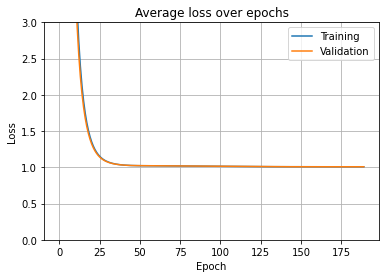

In [3]:
# Average loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.gca().set(
    title="Average loss over epochs", xlabel="Epoch", ylabel="Loss", ylim=(0, 3),
)
plt.grid()
plt.show()

In [4]:
# Interpretation
import dalex as dx
from sklearn.metrics import mean_gamma_deviance as deviance
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor().fit(X_train, y_train)
d0, d = (deviance(y_valid, m.predict(X_valid)) for m in (dummy, model))
print(f"% deviance explained: {(d0 - d) / d0:.2%}")

% deviance explained: 98.41%


In [5]:
def pred_fun(m, X):
    return m.predict(preprocessor.transform(X), batch_size=1000).flatten()


exp = dx.Explainer(
    model,
    data=df_valid[ord_features + ["carat"]],
    y=y_valid,
    predict_function=pred_fun,
    verbose=False,
)

vi = exp.model_parts()
vi.plot()

In [6]:
pdp_num = exp.model_profile(
    variables=["carat"], label="Partial depencence for numeric variables", verbose=False
)
pdp_num.plot()

pdp_ord = exp.model_profile(
    variable_type="categorical",
    variable_splits=dict(zip(ord_features, ord_levels)),
    label="Partial depencence for ordinal variables",
    verbose=False,
)
pdp_ord.plot(facet_scales="free")

C:\Users\Michael\anaconda3\envs\ml_lecture\lib\site-packages\dalex\predict_explanations\_ceteris_paribus\checks.py:16: UserWarning:

Variables taken from variables_splits



## Exercise 2

See lecture notes for a solution with embeddings